# Beam Search

In `chapter_seq2seq`, we discussed how to train an encoder-decoder with input and output sequences that are both of variable length. In this section, we are going to introduce how to use the encoder-decoder to predict sequences of variable length.

As in the previous section, when preparing to train the data set, we normally attach a special symbol "&lt;eos&gt;" after each sentence to indicate the termination of the sequence. We will continue to use this mathematical symbol in the discussion below. For ease of discussion, we assume that the output of the decoder is a sequence of text. Let the size of output text dictionary $\mathcal{Y}$ (contains special symbol "&lt;eos&gt;") be $\left|\mathcal{Y}\right|$, and the maximum length of the output sequence be $T'$. There are a total $\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$ types of possible output sequences. All the subsequences after the special symbol "&lt;eos&gt;" in these output sequences will be discarded.


## Greedy Search

First, we will take a look at a simple solution: greedy search. For any time step $t'$ of the output sequence, we are going to search for the word with the highest conditional probability from $|\mathcal{Y}|$ numbers of words, with

$$y_{t'} = \operatorname*{argmax}_{y \in \mathcal{Y}} \mathbb{P}(y \mid y_1, \ldots, y_{t'-1}, \boldsymbol{c})$$

as the output.  Once the "&lt;eos&gt;" symbol is detected, or the output sequence has reached its maximum length $T'$, the output is completed.

As we mentioned in out discussion of the decoder, the conditional probability of generating an output sequence based on the input sequence is $\prod_{t'=1}^{T'} \mathbb{P}(y_{t'} \mid y_1, \ldots, y_{t'-1}, \boldsymbol{c})$. We will take the output sequence with the highest conditional probability as the optimal sequence. The main problem with greedy search is that there is no guarantee that the optimal sequence will be obtained.

Take a look at the example below. We assume that there are four words "A", "B", "C", and "&lt;eos&gt;" in the output dictionary.  The four numbers under each time step in Figure 11.9 represent the conditional probabilities of generating "A", "B", "C", and "&lt;eos&gt;" at that time step.  At each time step, greedy search selects the word with the highest conditional probability. Therefore, the output sequence "A", "B", "C", "&lt;eos&gt;" will be generated in Figure 11.9. The conditional probability of this output sequence is $0.5\times0.4\times0.4\times0.6 = 0.048$.



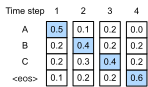

In [1]:
from IPython.display import SVG
SVG('../img/s2s_prob1.svg')


Fig.10.15.1: The four numbers under each time step represent the conditional probabilities of generating "A", "B", "C", and "&lt;eos&gt;" at that time step.  At each time step, greedy search selects the word with the highest conditional probability. 


Now, we will look at another example shown in Figure 11.10. Unlike in Figure 11.9, Figure 11.10 selects the word "C" for it has the second highest conditional probability at time step 2. Since the output subsequences of time steps 1 and 2, on which time step 3 is based, are changed from "A" and "B" in Fig. 10.9 to "A" and "C" in Fig. 10.10, the conditional probability of each word generated at time step 3 has also changed in Fig. 10.10. We choose the word "B", which has the highest conditional probability. Now, the output subsequences of time step 4 based on the first three time steps are "A", "C", and "B", which are different from "A", "B", and "C" in Fig. 10.9. Therefore, the conditional probability of generating each word in time step 4 in Figure 11.10 is also different from that in Figure 11.9. We find that the conditional probability of the output sequence "A", "C", "B", "&lt;eos&gt;" at the current time step is $0.5\times0.3 \times0.6\times0.6=0.054$, which is higher than the conditional probability of the output sequence obtained by greedy search. Therefore, the output sequence "A", "B", "C", "&lt;eos&gt;" obtained by the greedy search is not an optimal sequence.


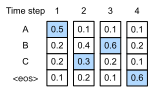

In [2]:
SVG('../img/s2s_prob2.svg')


Fig.10.15.2: The four numbers under each time step represent the conditional probabilities of generating "A", "B", "C", and "&lt;eos&gt;" at that time step.  At time step 2, the word "C", which has the second highest conditional probability, is selected. 

## Exhaustive Search

If the goal is to obtain the optimal sequence, we may consider using exhaustive search: an exhaustive examination of all possible output sequences, which outputs the sequence with the highest conditional probability.

Although we can use an exhaustive search to obtain the optimal sequence, its computational overhead $\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$ is likely to be excessively high. For example, when $|\mathcal{Y}|=10000$ and $T'=10$, we will need to evaluate $10000^{10} = 10^{40}$ sequences. This is next to impossible to complete. The computational overhead of greedy search is $\mathcal{O}(\left|\mathcal{Y}\right|T')$, which is usually significantly less than the computational overhead of an exhaustive search. For example, when $|\mathcal{Y}|=10000$ and $T'=10$, we only need to evaluate $10000\times10=1\times10^5$ sequences.


## Beam Search

Beam search is an improved algorithm based on greedy search. It has a hyper-parameter named beam size. We set it to $k$. At time step 1, we select $k$ words with the highest conditional probability to be the first words of the $k$ candidate output sequences. For each subsequent time step, we are going to select the $k$ output sequences with the highest conditional probability from the total of $k\left|\mathcal{Y}\right|$ possible output sequences based on the $k$ candidate output sequences from the previous time step. These will be the candidate output sequence for that time step. Finally, we will filter out the sequences containing the special symbol "&lt;eos&gt;" from the candidate output sequences of each time step and discard all the subsequences after it to obtain a set of final candidate output sequences.

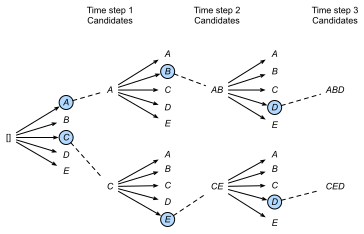

In [3]:
SVG('../img/beam_search.svg')

Fig.10.15.3: The beam search process. The beam size is 2 and the maximum length of the output sequence is 3. The candidate output sequences are $A$, $C$, $AB$, $CE$, $ABD$, and $CED$. 

Figure 11.11 demonstrates the process of beam search with an example. Suppose that the vocabulary of the output sequence only contains five elements: $\mathcal{Y} = \{A, B, C, D, E\}$ where one of them is a special symbol “&lt;eos&gt;”. Set beam size to 2, the maximum length of the output sequence to 3. At time step 1 of the output sequence, suppose the words with the highest conditional probability $\mathbb{P}(y_1 \mid \boldsymbol{c})$ are $A$ and $C$. At time step 2, we compute $\mathbb{P}(A, y_2 \mid \boldsymbol{c}) = \mathbb{P}(A \mid \boldsymbol{c})\mathbb{P}(y_2 \mid A, \boldsymbol{c})$ and $\mathbb{P}(C, y_2 \mid \boldsymbol{c}) = \mathbb{P}(C \mid \boldsymbol{c})\mathbb{P}(y_2 \mid C, \boldsymbol{c})$ for all $y_2 \in \mathcal{Y}$, and pick the largest two among these 10 values: say $\mathbb{P}(A, B \mid \boldsymbol{c})$ and $\mathbb{P}(C, E \mid \boldsymbol{c})$. Then at time step 3, we compute $\mathbb{P}(A, B, y_3 \mid \boldsymbol{c}) = \mathbb{P}(A, B \mid \boldsymbol{c})\mathbb{P}(y_3 \mid A, B, \boldsymbol{c})$ and $\mathbb{P}(C, E, y_3 \mid \boldsymbol{c}) = \mathbb{P}(C, E \mid \boldsymbol{c})\mathbb{P}(y_3 \mid C, E, \boldsymbol{c})$ for all $y_3 \in \mathcal{Y}$, and pick the largest two among these 10 values: say $\mathbb{P}(A, B, D \mid \boldsymbol{c})$ and $\mathbb{P}(C, E, D \mid  \boldsymbol{c})$. As a result, we obtain 6 candidates output sequences: (1) $A$; (2)$C$; (3) $A$, $B$; (4)$C$, $E$; (5)$A$, $B$, $D$; and (6)$C$, $E$, $D$. In the end, we will get the set of final candidate output sequences based on these 6 sequences.

In the set of final candidate output sequences, we will take the sequence with the highest score as the output sequence from those below:

$$ \frac{1}{L^\alpha} \log \mathbb{P}(y_1, \ldots, y_{L}) = \frac{1}{L^\alpha} \sum_{t'=1}^L \log \mathbb{P}(y_{t'} \mid y_1, \ldots, y_{t'-1}, \boldsymbol{c}),$$

Here, $L$ is the length of the final candidate sequence and the selection for $\alpha$ is generally 0.75. The $L^\alpha$ on the denominator is a penalty on the logarithmic addition scores for the longer sequences above. The computational overhead $\mathcal{O}(k\left|\mathcal{Y}\right|T')$ of the beam search can be obtained through analysis. The result is a computational overhead between those of greedy search and exhaustive search. In addition, greedy search can be treated as a beam search with a beam size of 1. Beam search strikes a balance between computational overhead and search quality using a flexible beam size of $k$.


## Summary

* Methods for predicting variable-length sequences include greedy search, exhaustive search, and beam search.
* Beam search strikes a balance between computational overhead and search quality using a flexible beam size.


## Exercises

* Can we treat an exhaustive search as a beam search with a special beam size? Why?
* We used language models to generate sentences in `chapter_rnn_scratch`. Which kind of search does this output use? Can you improve it?
